In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D,Activation,\
                         LeakyReLU, Flatten, Reshape,Add, \
                         Conv2DTranspose , BatchNormalization, \
                         Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

/Users/ardavan/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ardavan/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ardavan/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ardavan/anaconda/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
import numpy as np
import pydot
import graphviz
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from time import  time

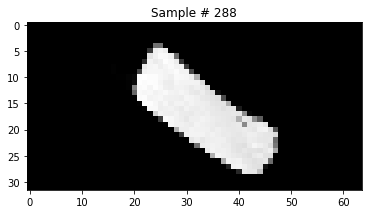

In [3]:
brush_stroke_raw_data = np.load("../data_brushstrokes/brush_strokes_32x64_vae.npy")
brush_stroke_raw_data = np.expand_dims(brush_stroke_raw_data, axis= 3)
brush_stroke_raw_data -= 1
brush_stroke_raw_data *= -1

sample_index = np.random.randint(0,brush_stroke_raw_data.shape[0] )
sample = brush_stroke_raw_data[sample_index]
plt.imshow(sample.reshape(sample.shape[:-1]),cmap = 'gray')
plt.title("Sample # {}".format(sample_index))
plt.show()

In [4]:
x_train,x_test  = train_test_split (brush_stroke_raw_data)
print (x_train.shape)

(556, 32, 64, 1)


In [5]:
input_dim = x_train.shape[1:] #(28,28,1)
n_layers_encoder = 5
n_layers_deocer = 5
z_dim = 8

learning_rate = 0.0005

encoder_conv_filtes = [32,64,64,64,64,64]
encoder_conv_kernel_size = [3,3,3,3,3,3]
encoder_conv_strides = [1,2,2,2,2,1]

decoder_conv_t_filters = [64,64,64,64,32,1]
decoder_conv_t_kernel_size = [3,3,3,3,3,3]
decoder_conv_t_strides = [1,2,2,2,2,1]

In [6]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = np.expand_dims(x_train, axis=len(x_train.shape))
# x_test = np.expand_di ms(x_test, axis=len(x_test.shape))
# print (x_train.shape)

In [7]:
def res_layer(x, n_filters):
    res = Conv2D(filters= n_filters,
                 kernel_size= 3,
                 strides= 1,
                 padding = 'same')(x)
    res = BatchNormalization()(res)
    res = LeakyReLU()(res)
    res =  Conv2D(filters= n_filters,
                  kernel_size= 3,
                  strides= 1,
                  padding = 'same')(res)
    res = BatchNormalization()(res)
    res = Add()([x, res])
    return res

In [8]:
encoder_input = Input(shape = input_dim, name = 'encoder_input')
x = encoder_input

for i in range (n_layers_encoder):
    conv_layer = Conv2D(
                filters = encoder_conv_filtes[i],
                kernel_size= encoder_conv_kernel_size[i],
                strides = encoder_conv_strides[i],
                padding = 'same',
                name= 'Encoder_conv_{}'.format(i))
    x = conv_layer(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = res_layer(x, encoder_conv_filtes[i])
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)

mu = Dense (z_dim, name='mu')(x)
log_var = Dense(z_dim, name = 'log_var')(x)

encoder_mu_log_var = Model (encoder_input, (mu, log_var))
#encoder_mu_log_var.summary()
#plot_model(encoder_mu_log_var)

In [9]:
def sampling(args):
    '''
    Basically, we want to generate epsilon from a normal distribution
    with mean of zero and stadard deviation of 1. Then we use this 
    epsilon to sample from the target distribution, which we are learning.
    The problem is that we have log_var, not standard deviation, so
    we use K.exp(log_var/2) to convert log_var to stddev!
    Then we put mu and this bew stddev in the normal distribution formula
    (mu+stddev*val)and generate our samples! 
    '''
    mu, log_var = args
    epsilon = K.random_normal(shape = K.shape(mu), mean = 0, stddev=1)
    return mu + K.exp(log_var/2) * epsilon

# Lambda is a wrapper function to add new functions to Keras
# note the way it wraps the arguments as a list!
encoder_output =  Lambda(sampling, name = 'encoder_output')([mu, log_var])
encoder = Model (encoder_input, encoder_output)
#plot_model(encoder)

In [10]:
decoder_input = Input(shape = (z_dim,), name = 'decoder_input')
x = decoder_input
x = Dense(np.prod(shape_before_flattening))(x)
x = Reshape(shape_before_flattening)(x)
for i in range (n_layers_deocer):
    conv_t_layer = Conv2DTranspose(
                        filters = decoder_conv_t_filters[i],
                        kernel_size = decoder_conv_t_kernel_size[i],
                        strides = decoder_conv_t_strides[i],
                        padding = 'same',
                        name = "decoder_conv_t_{}".format(i))

    x = conv_t_layer(x)
    x = BatchNormalization()(x)
    if i < n_layers_deocer :
        x = LeakyReLU()(x)
        x = res_layer(x, decoder_conv_t_filters[i])
    else:
        x = Activation('sigmoid')(x)
x = Conv2DTranspose(
                        filters = 1,
                        kernel_size = 3,
                        strides = 1,
                        padding = 'same',
                        name = "decoder_conv_t_last")(x)
decoder_output = x
decoder = Model(decoder_input, decoder_output, name = "decoder_model")

In [11]:
decoder.summary()
#plot_model(decoder)

Model: "decoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          4608        decoder_input[0][0]              
__________________________________________________________________________________________________
reshape (Reshape)               (None, 2, 4, 64)     0           dense[0][0]                      
__________________________________________________________________________________________________
decoder_conv_t_0 (Conv2DTranspo (None, 2, 4, 64)     36928       reshape[0][0]                    
______________________________________________________________________________________

In [12]:
r_loss_factor = 100000

In [13]:
def vae_reconstruction_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true-y_pred), axis= [1,2,3])
    return r_loss* r_loss_factor

def vae_kl_loss(y_true, y_pred):
    kl_loss = -0.5*K.sum(1+log_var-K.square(mu)-K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss  = vae_reconstruction_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return r_loss + kl_loss    

In [14]:
model_input = encoder_input
model_output = decoder(encoder_output)
model = Model(model_input, model_output, name="AE_model")

In [15]:
model.summary()
#plot_model(model)

Model: "AE_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 64, 1)]  0                                            
__________________________________________________________________________________________________
Encoder_conv_0 (Conv2D)         (None, 32, 64, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 32)   0           Encoder_conv_0[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 32)   128         leaky_re_lu[0][0]                
___________________________________________________________________________________________

In [16]:
optimizer = Adam(lr=learning_rate)
model.compile(optimizer = optimizer, 
              loss= vae_loss, 
              metrics = [vae_reconstruction_loss,vae_kl_loss])

In [17]:
%%time 
model.fit(x = x_train,
          y = x_train,
          batch_size = 32,
          shuffle = True,
          epochs = 2)

Train on 556 samples
Epoch 1/2
556/556 [==============================] - 24s 43ms/sample - loss: 77261.1282 - vae_reconstruction_loss: 74210.8203 - vae_kl_loss: 3050.3118
Epoch 2/2
556/556 [==============================] - 15s 26ms/sample - loss: 815519614.2528 - vae_reconstruction_loss: 11209.7295 - vae_kl_loss: 815508352.0000
CPU times: user 1min 59s, sys: 33.1 s, total: 2min 32s
Wall time: 52.3 s


In [20]:
scores = model.evaluate(x_test, x_test, verbose = 0)
for i in range (len (model.metrics_names)):
    print (model.metrics_names[i], ":", int(scores[i]))
    
model.save("VAE_saved_weight_good_quality_for_test_001.h5".format(time()))
encoder.save("Encoder_saved_weight_test_001.h5".format(time()))
decoder.save("Decoder_saved_weight_test_001.h5".format(time()))

loss : 8254
vae_reconstruction_loss : 8254
vae_kl_loss : 0


latent = 4
loss : 2602
vae_reconstruction_loss : 2555
vae_kl_loss : 46

**********************
loss : 3131
vae_reconstruction_loss : 3087
vae_kl_loss : 44
**********************

latent = 8

loss : 2024
vae_reconstruction_loss : 1951
vae_kl_loss : 72

***************
loss : 243
vae_reconstruction_loss : 208
vae_kl_loss : 34
*********
loss : 228
vae_reconstruction_loss : 191
vae_kl_loss : 36
*********
loss : 1325
vae_reconstruction_loss : 1249
vae_kl_loss : 76
*********
loss : 1504
vae_reconstruction_loss : 1391
vae_kl_loss : 112
*********
loss : 4998
vae_reconstruction_loss : 4732
vae_kl_loss : 266

129
(1, 32, 64, 1)


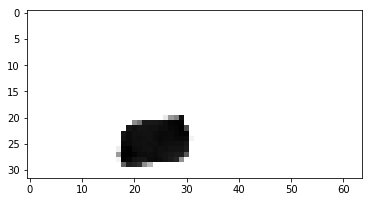

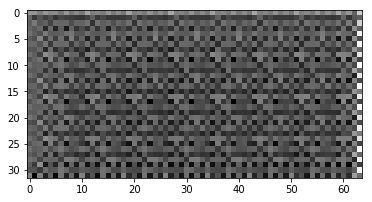

In [26]:
index = np.random.randint(0, x_test.shape[0])
sample = x_test[index:index+1] 
sample_ = sample - 1
sample_ *= -1
print (index)
print (sample.shape)
plt.imshow(sample_.reshape(x_test.shape[1:-1]), cmap='gray')
plt.show()

rec = model.predict(sample)
rec -= 1
rec *= -1
plt.imshow(rec.reshape(x_test.shape[1:-1]), cmap='gray')
plt.show()

In [63]:
def plot_grid(imgs):
    fig = plt.figure(figsize=(24., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(5,4),  # creates 5x4 grid of axes
                     axes_pad=0.8)  # pad between axes in inch.)

    for i in range(len(grid)):
        sample = imgs[i].reshape(32,64)
        sample -= 1
        sample *= -1
        grid[i].axis('off')
        grid[i].imshow(sample, cmap= 'gray')

        plt.axis('off')
    plt.show()

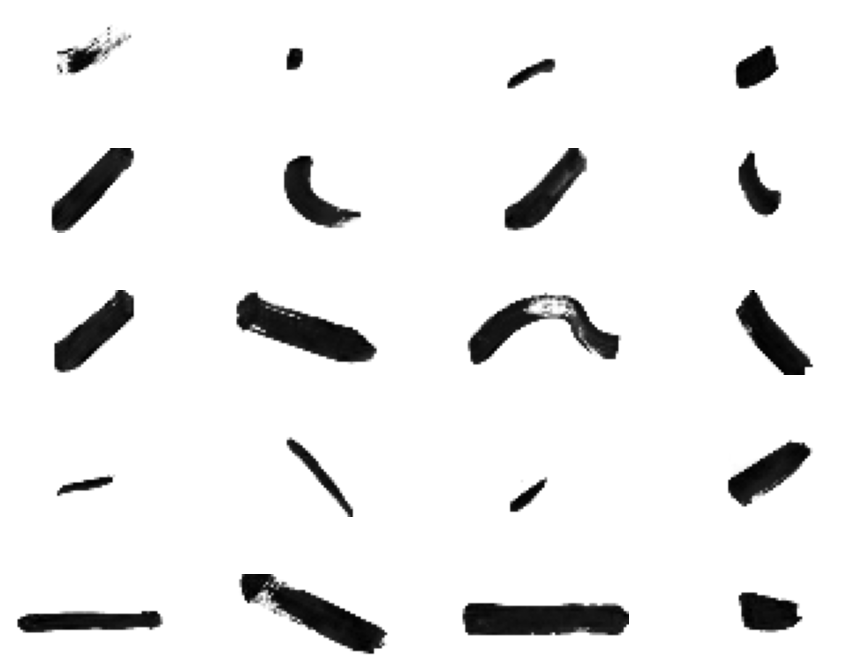

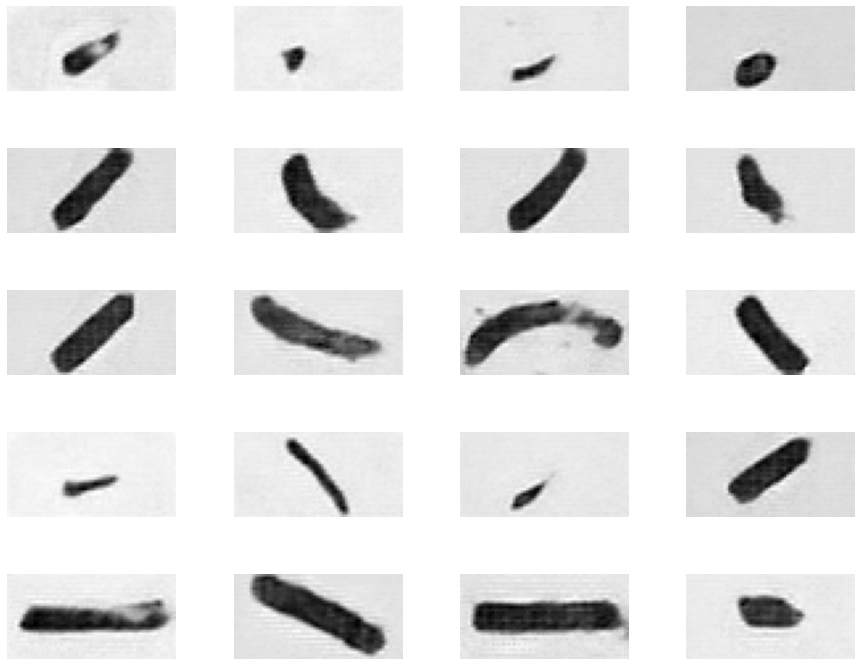

In [66]:
rec_samples = model.predict(x_test)
sample_ind = list(range(20,45))

orig = x_test[sample_ind]
rec = rec_samples[sample_ind]

plot_grid(orig)
plot_grid(rec)

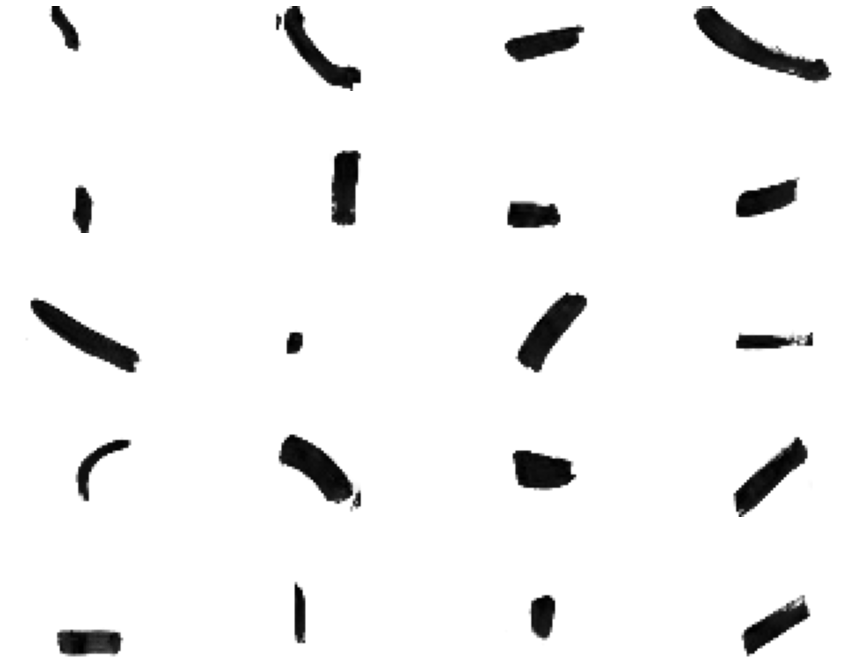

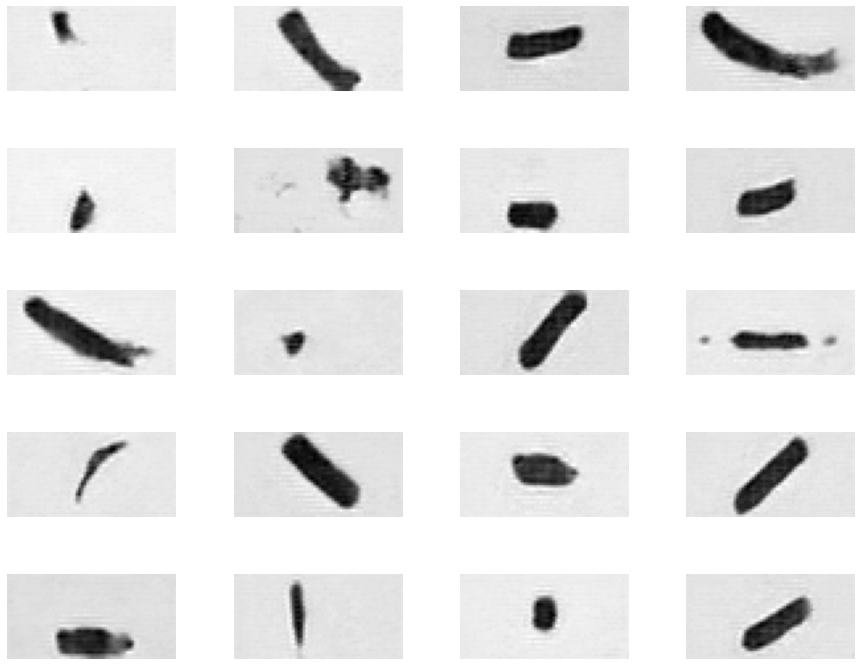

In [65]:
rec_samples = model.predict(x_test)
sample_ind = np.random.choice(range(rec_samples.shape[0]), size = 25, replace = False)

orig = x_test[sample_ind]
rec = rec_samples[sample_ind]

plot_grid(orig)
plot_grid(rec)

In [107]:
def test_a_sample(sample):
    sample_ = sample - 1
    sample_ *= -1
    print (index)
    plt.imshow(sample_.reshape(x_test.shape[1:-1]), cmap='gray')
    plt.show()

    rec = model.predict(sample)
    rec -= 1
    rec *= -1
    plt.imshow(rec.reshape(x_test.shape[1:-1]), cmap='gray')
    plt.show()
    
    

156


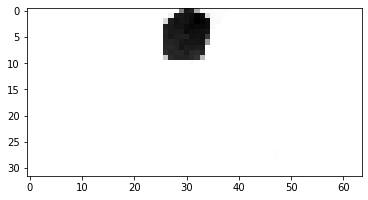

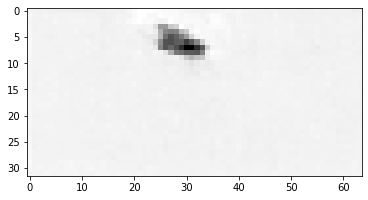

In [108]:
index = np.random.randint(0, x_test.shape[0])
sample = x_test[index:index+1] 
test_a_sample(sample)

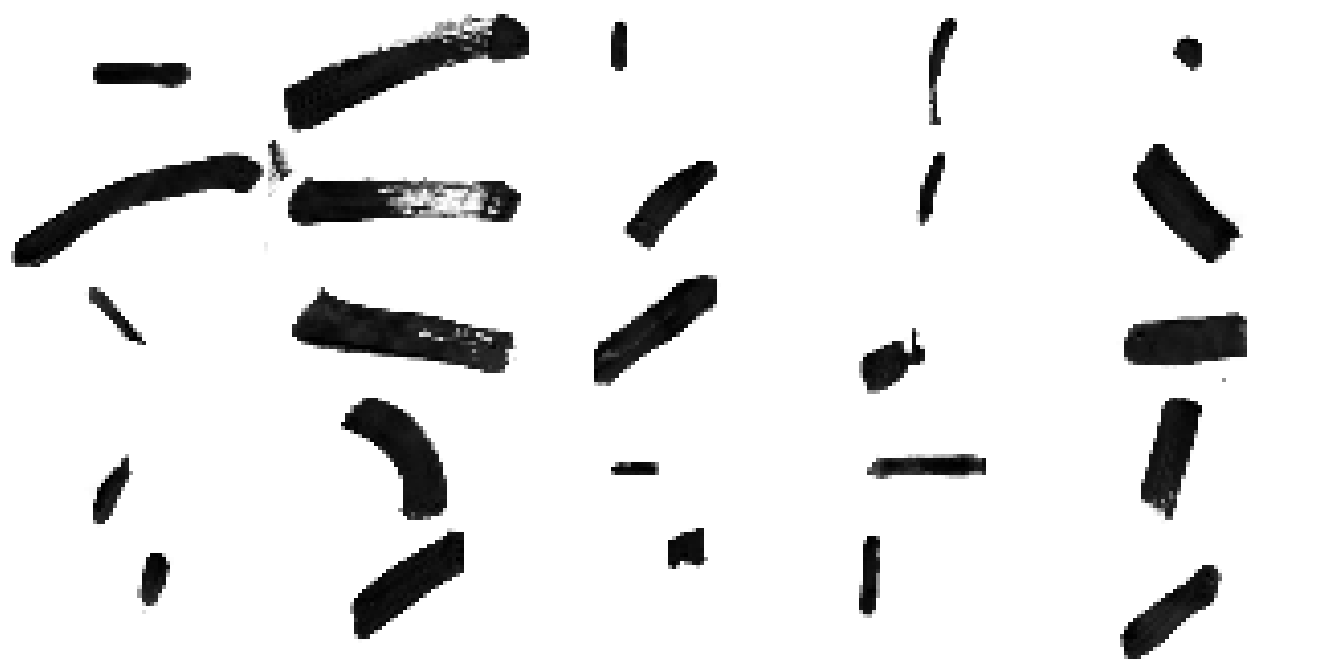

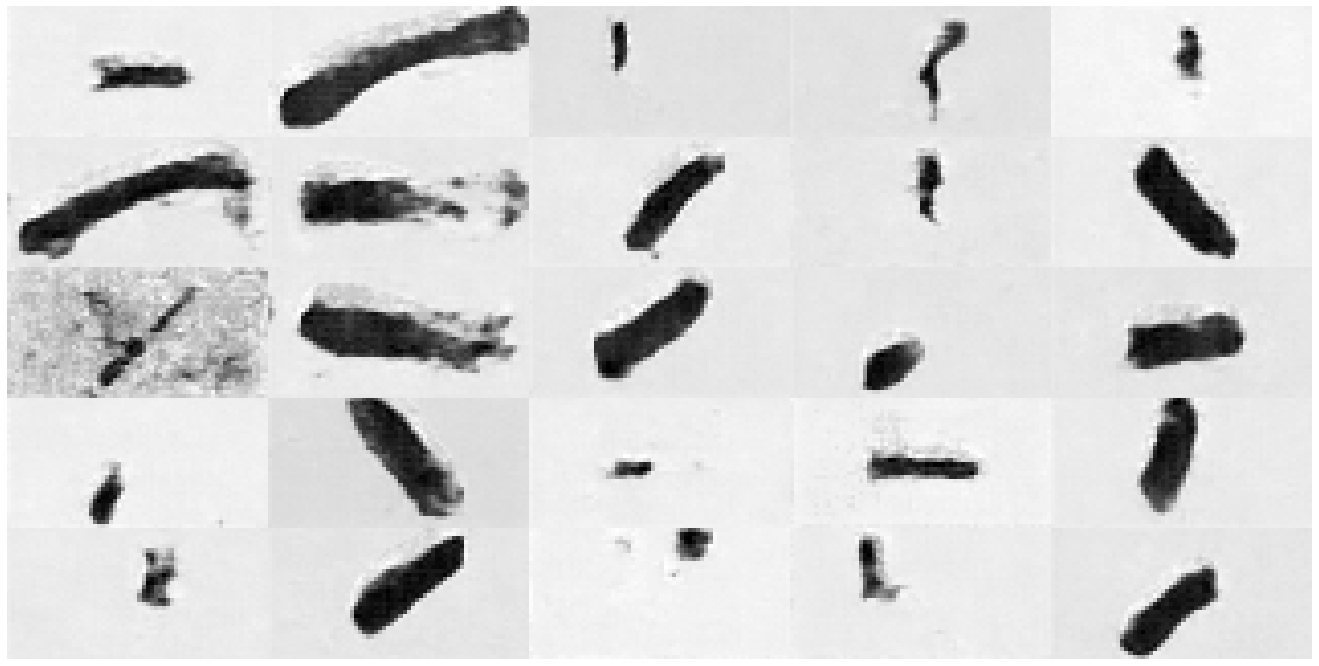

In [83]:
rec_samples = model.predict(x_test)
sample_ind = np.random.choice(range(rec_samples.shape[0]), size = 25, replace = False)

orig = x_test[sample_ind]
rec = rec_samples[sample_ind]

plot_grid(orig)
plot_grid(rec)

153


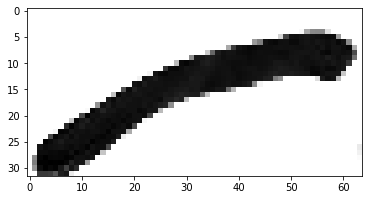

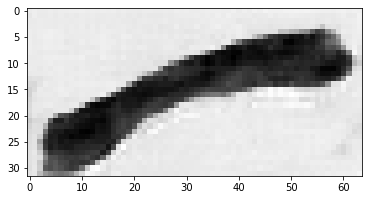

In [73]:
index = np.random.randint(0, x_test.shape[0])
sample = x_test[index:index+1] 
sample_ = sample - 1
sample_ *= -1
print (index)
plt.imshow(sample_.reshape(x_test.shape[1:-1]), cmap='gray')
plt.show()

rec = model.predict(sample)
rec -= 1
rec *= -1
plt.imshow(rec.reshape(x_test.shape[1:-1]), cmap='gray')
plt.show()

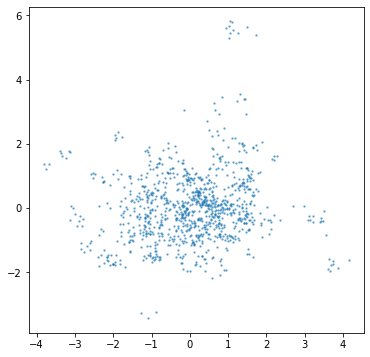

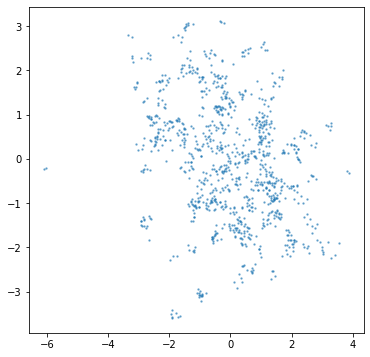

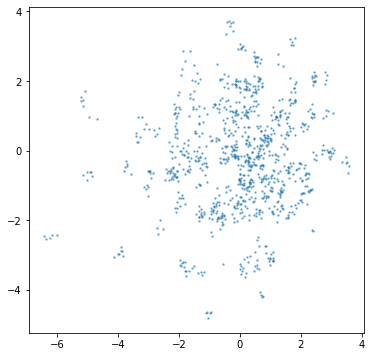

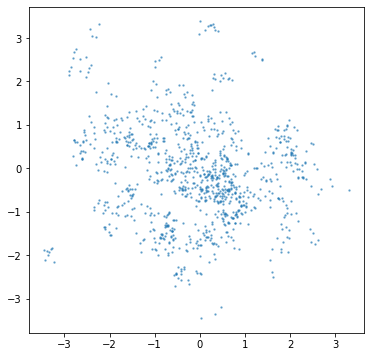

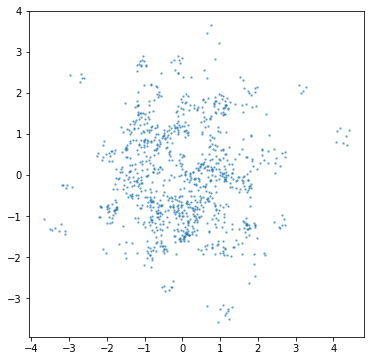

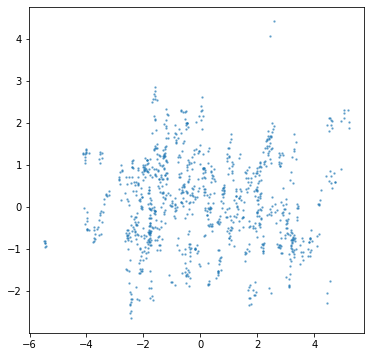

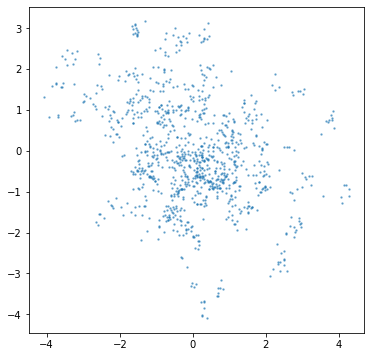

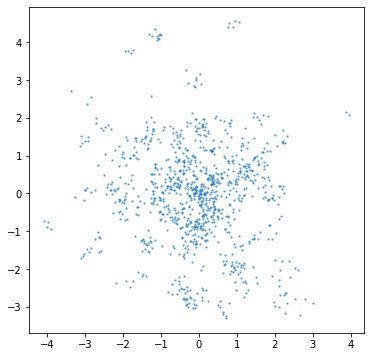

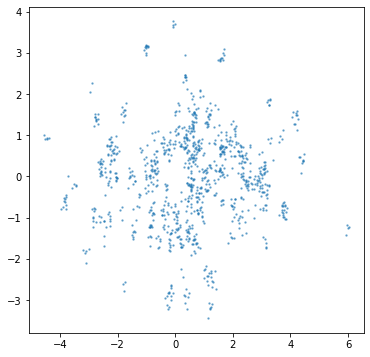

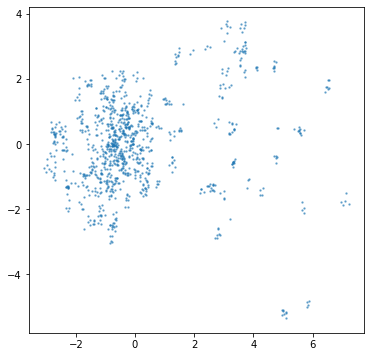

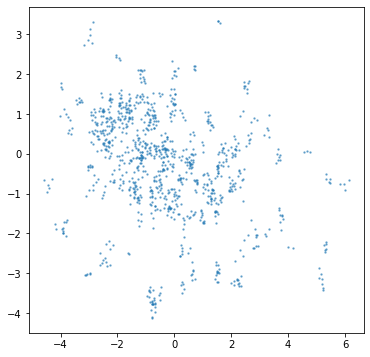

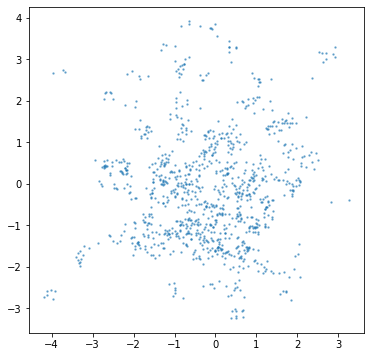

In [102]:
number_of_samples = 1000
grid_size = 15
figsize = 6

example_idx = np.random.choice(range(len(x_test)), number_of_samples)
example_images = x_test[example_idx]
#example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)
for i in range (12):
    plt.figure(figsize=(figsize,figsize))
    plt.scatter(z_points[:,0+2*i],z_points[:,1+2*i], cmap='rainbow',  alpha = 0.5, s = 2 )
    #plt.colorbar()
    plt.show()

(100, 32, 64, 1)


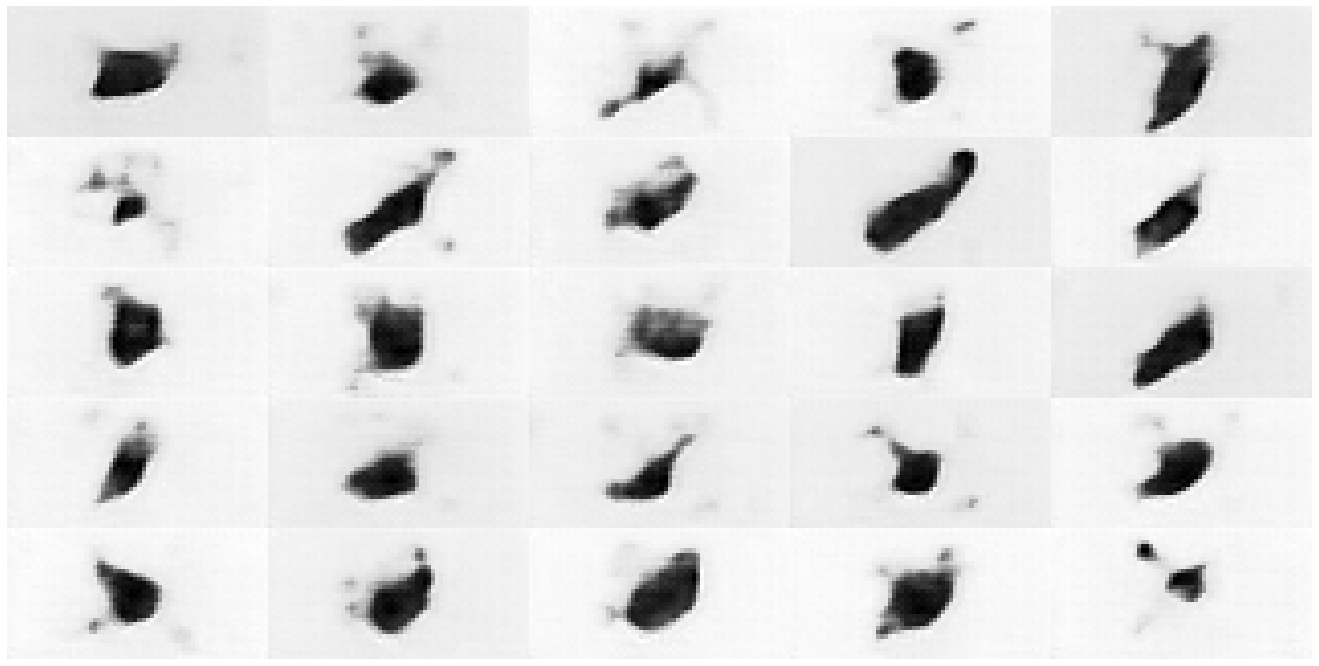

In [111]:
sample_vec = np.random.rand(25,32) *2 -1 
sample_vec = np.random.normal(scale = 0.5, size = (100,32))
rec = decoder.predict(sample_vec)
print (rec.shape)

fig = plt.figure(figsize=(24., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5,5),  # creates 2x2 grid of axes
                 axes_pad=0.0)  # pad between axes in inch.)
                 
for i in range(len(grid)):
    sample = rec[i].reshape(32,64)
    sample -= 1
    sample *= -1
    grid[i].axis('off')
    grid[i].imshow(sample, cmap= 'gray')

    plt.axis('off')
plt.show()


64


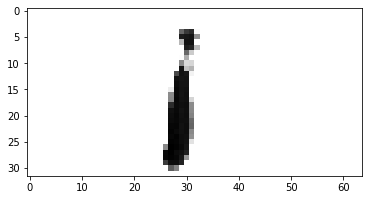

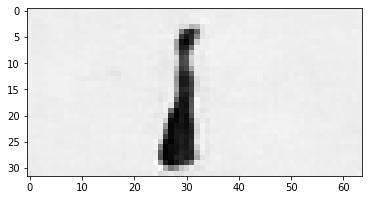

In [62]:
index = np.random.randint(0, x_test.shape[0])
sample = x_test[index:index+1] 
sample_ = sample - 1
sample_ *= -1
print (index)
plt.imshow(sample_.reshape(x_test.shape[1:-1]), cmap='gray')
plt.show()

rec = model.predict(sample)
rec -= 1
rec *= -1
plt.imshow(rec.reshape(x_test.shape[1:-1]), cmap='gray')
plt.show()

0.0
1.0


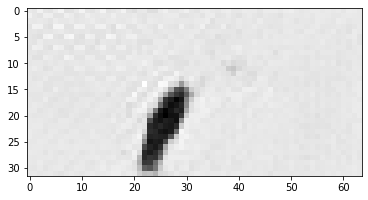

In [75]:
rec__ = np.interp(rec, (rec.min(), rec.max()), (0, +1))
print (rec__.min())
print (rec__.max())

plt.imshow(rec__.reshape(x_test.shape[1:-1]), cmap='gray')
plt.show()

39


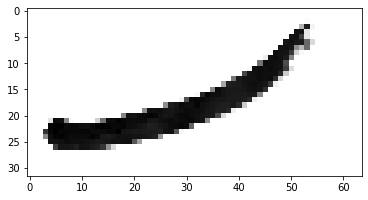

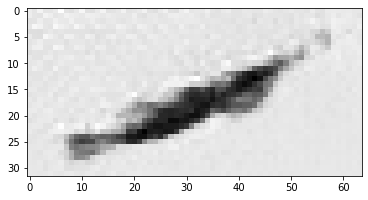

In [67]:
index = np.random.randint(0, x_test.shape[0])
sample = x_test[index:index+1] 
sample_ = sample - 1
sample_ *= -1
print (index)
plt.imshow(sample_.reshape(x_test.shape[1:-1]), cmap='gray')
plt.show()

rec = model.predict(sample)
rec -= 1
rec *= -1
plt.imshow(rec.reshape(x_test.shape[1:-1]), cmap='gray')
plt.show()

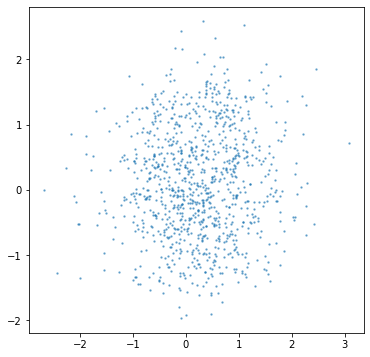

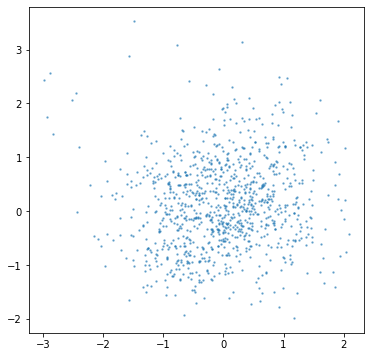

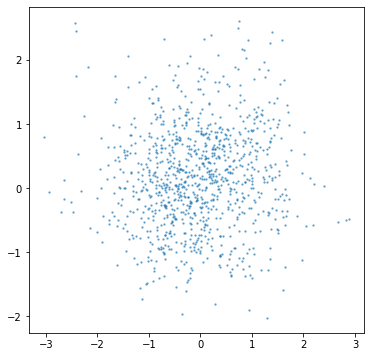

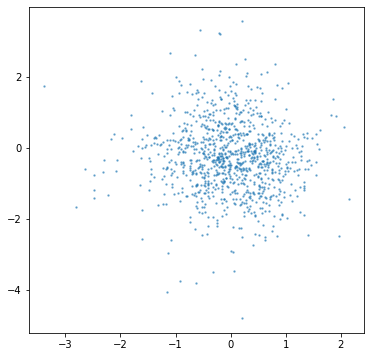

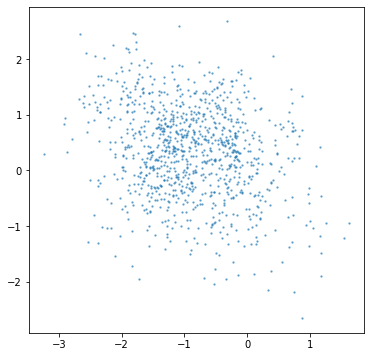

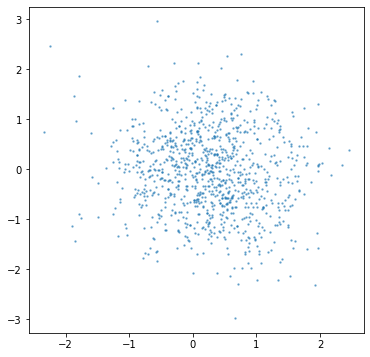

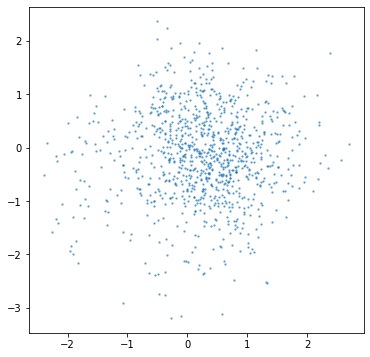

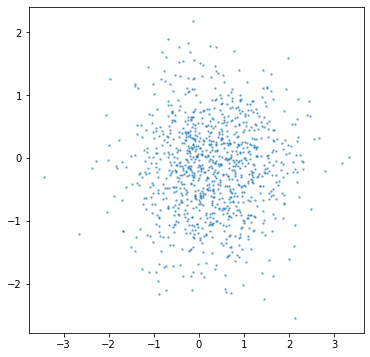

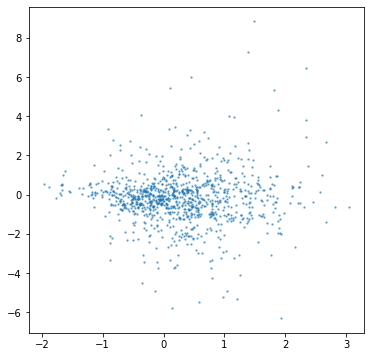

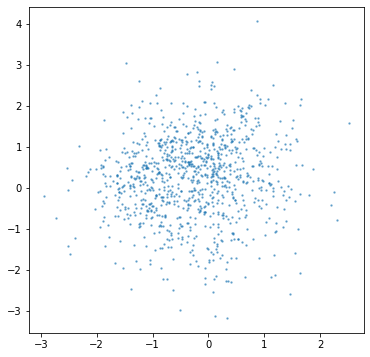

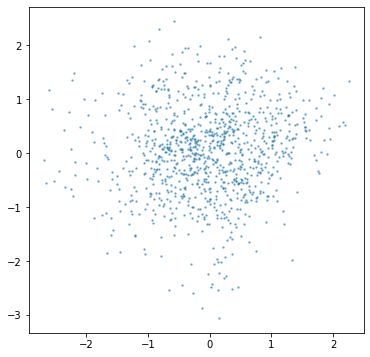

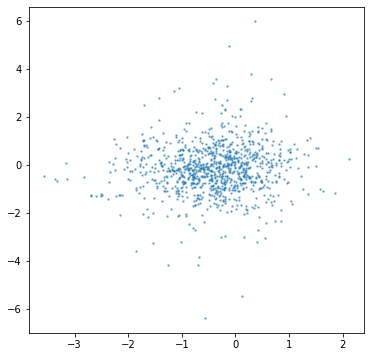

In [21]:
number_of_samples = 1000
grid_size = 15
figsize = 6

example_idx = np.random.choice(range(len(x_test)), number_of_samples)
example_images = x_test[example_idx]
#example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)
for i in range (12):
    plt.figure(figsize=(figsize,figsize))
    plt.scatter(z_points[:,0+2*i],z_points[:,1+2*i], cmap='rainbow',  alpha = 0.5, s = 2 )
    #plt.colorbar()
    plt.show()

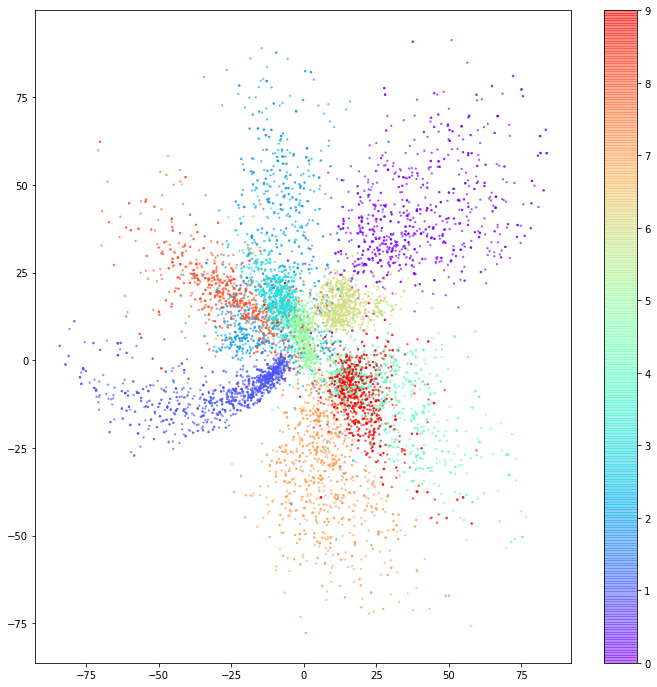

In [47]:
number_of_samples = 10000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), number_of_samples)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)

plt.figure(figsize=(figsize,figsize))
plt.scatter(z_points[:,0],z_points[:,1], cmap='rainbow', c = example_labels, alpha = 0.5, s = 2 )
plt.colorbar()
plt.show()